## Import Library

In [ ]:
import os
import shutil
from google.colab import drive
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Gathering & Preprocessing Data

In [ ]:
import kagglehub

# Download latest version
# path = kagglehub.dataset_download("bagusarioyudanto/plant-classification")
path = kagglehub.dataset_download("bagusarioyudanto/15-plant-classification")

print("Path to dataset files:", path)

100%|██████████| 1.04G/1.04G [00:21<00:00, 51.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bagusarioyudanto/15-plant-classification/versions/2


In [ ]:
os.listdir(path)

['delima',
 'tomat',
 'melati',
 'bunga_matahari',
 'kamboja',
 'okra',
 'lidah_buaya',
 'kelor',
 'nanas',
 'sorgum',
 'gandum',
 'jambu_batu',
 'jagung',
 'singkong',
 'kakao']

In [ ]:
from PIL import Image
import os

def check_and_convert_to_jpg(file_path):
    # Memeriksa apakah file ada
    if not os.path.exists(file_path):
        print(f"File {file_path} tidak ditemukan!")
        return

    # Membuka gambar menggunakan Pillow
    try:
        img = Image.open(file_path)

        # Mengecek format gambar
        if img.format.lower() == 'jpeg' or img.format.lower() == 'jpg':
            print(f"File {file_path} sudah dalam format JPG.")
        else:
            # Membuat nama file baru untuk format JPG
            new_file_path = os.path.splitext(file_path)[0] + '.jpg'

            # Mengonversi gambar ke format JPG
            img.convert('RGB').save(new_file_path, 'JPEG')
            print(f"File {file_path} telah dikonversi menjadi {new_file_path}")

    except Exception as e:
        print(f"Terjadi kesalahan saat membuka file: {e}")

In [ ]:
data_dir = path

In [ ]:
for name in os.listdir(data_dir):
  for filename in os.listdir(f"{data_dir}/{name}/"):
    check_and_convert_to_jpg(f'{data_dir}/{name}/{filename}')

Streaming output truncated to the last 5000 lines.
File /root/.cache/kagglehub/datasets/bagusarioyudanto/15-plant-classification/versions/2/okra/okra_28.jpg sudah dalam format JPG.
File /root/.cache/kagglehub/datasets/bagusarioyudanto/15-plant-classification/versions/2/okra/okra_198.jpg sudah dalam format JPG.
File /root/.cache/kagglehub/datasets/bagusarioyudanto/15-plant-classification/versions/2/okra/okra_810.jpg sudah dalam format JPG.
File /root/.cache/kagglehub/datasets/bagusarioyudanto/15-plant-classification/versions/2/okra/okra_902.jpg sudah dalam format JPG.
File /root/.cache/kagglehub/datasets/bagusarioyudanto/15-plant-classification/versions/2/okra/okra_519.jpg sudah dalam format JPG.
File /root/.cache/kagglehub/datasets/bagusarioyudanto/15-plant-classification/versions/2/okra/okra_48.jpg sudah dalam format JPG.
File /root/.cache/kagglehub/datasets/bagusarioyudanto/15-plant-classification/versions/2/okra/okra_509.jpg sudah dalam format JPG.
File /root/.cache/kagglehub/datase

In [ ]:
train, val = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(224,224),
    label_mode='categorical',
    validation_split=0.2,
    subset='both',
    seed=123,
    batch_size=32
)

train_set = train.shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_set = val.prefetch(tf.data.AUTOTUNE)

Found 7882 files belonging to 15 classes.
Using 6306 files for training.
Using 1576 files for validation.


In [ ]:
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Pastikan tipe float32
    return image, label

train_set = train_set.map(normalize_image)
val_set = val_set.map(normalize_image)

# Building Model Using InceptionV3

In [ ]:
base_model = tf.keras.applications.InceptionV3(
              input_shape=(224,224,3),
              weights='imagenet',
              include_top=False,
              )

base_model_output = base_model.get_layer('mixed7').output
model_inceptionv3 = tf.keras.models.Model(inputs=base_model.input, outputs=base_model_output)

data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomTranslation(0.2,0.2, fill_mode='nearest'),
    tf.keras.layers.RandomZoom(0.2, fill_mode='nearest'),
    tf.keras.layers.RandomRotation(0.1, fill_mode='nearest')
])

input = tf.keras.Input(shape=(224,224,3))
x = data_aug(input)
x = model_inceptionv3(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(15, activation='softmax')(x)


model = tf.keras.Model(inputs=input, outputs=output)

#unfreeze several layer from trainable layer
for layer in base_model.layers:
    layer.trainable = False

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-7,
#     decay_steps=10000,
#     decay_rate=0.9
# )

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
history = model.fit(train_set, validation_data=val_set, epochs=30)

Epoch 1/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 23s 112ms/step - accuracy: 0.6242 - loss: 1.2384 - val_accuracy: 0.7100 - val_loss: 0.9282
Epoch 2/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 62s 219ms/step - accuracy: 0.6469 - loss: 1.1850 - val_accuracy: 0.7443 - val_loss: 0.8301
Epoch 3/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 61s 110ms/step - accuracy: 0.6540 - loss: 1.1340 - val_accuracy: 0.7322 - val_loss: 0.8745
Epoch 4/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 39s 103ms/step - accuracy: 0.6763 - loss: 1.0744 - val_accuracy: 0.7430 - val_loss: 0.8301
Epoch 5/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.6839 - loss: 1.0769 - val_accuracy: 0.7532 - val_loss: 0.8082
Epoch 6/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - accuracy: 0.6850 - loss: 1.0259 - val_accuracy: 0.7513 - val_loss: 0.8025
Epoch 7/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - accuracy: 0.6897 - loss: 0.9953 - val_accuracy: 0.7525 - val_loss: 0.7971
Epoch 8/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - accuracy: 0.7115 - loss: 0

KeyboardInterrupt: 

In [ ]:
def plot_acc(history):
  acc = history.history['accuracy']
  loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  epochs = len(acc)



  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

  ax[0].plot(range(epochs), acc, label='training accuracy')
  ax[0].plot(range(epochs), val_acc, label='validation accuracy')
  ax[0].legend()
  ax[0].set_title('Training vs Validation Accuracy')
  ax[0].set_ylabel('Accuracy')
  ax[0].set_xlabel('Epochs')

  ax[1].plot(range(epochs), loss, label='training loss')
  ax[1].plot(range(epochs), val_loss, label='validation loss')
  ax[1].legend()
  ax[1].set_title('Training vs Validation Loss')
  ax[1].set_ylabel('Loss')
  ax[1].set_xlabel('Epochs')

  plt.suptitle('Menggunakan Transfer Learning')
  fig.show()

In [ ]:
plot_acc(history)

NameError: name 'history' is not defined

In [ ]:
model.save('model_AmbatoPlant_InceptionV3_15_class_V1.keras')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r '/content/model_AmbatoPlant_InceptionV3_15_class_V1.keras' '/content/drive/MyDrive/Colab Notebooks/Model Inception 15 class'

In [ ]:
train.class_names

['bunga_matahari',
 'delima',
 'gandum',
 'jagung',
 'jambu_batu',
 'kakao',
 'kamboja',
 'kelor',
 'lidah_buaya',
 'melati',
 'nanas',
 'okra',
 'singkong',
 'sorgum',
 'tomat']

Upload gambar yang ingin diprediksi:


Saving jambubatu1.jpg to jambubatu1.jpg

Hasil prediksi untuk gambar jambubatu1.jpg:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


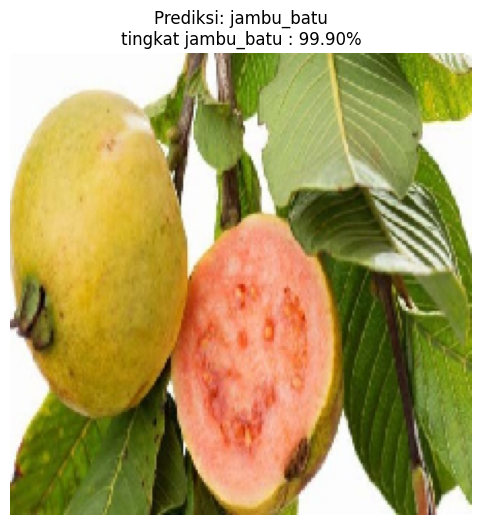

Kelas: jambu_batu
tingkat : jambu_batu 99.90%


In [ ]:
from google.colab import files

class_names = train.class_names

def predict_image(image_path, model, class_names):
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(224, 224)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f'Prediksi: {predicted_class}\ntingkat {predicted_class} : {confidence:.2%}')
    plt.axis('off')
    plt.show()

    return predicted_class, confidence

print("Upload gambar yang ingin diprediksi:")
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\nHasil prediksi untuk gambar {filename}:")
    predicted_class, confidence = predict_image(filename, model, class_names)
    print(f"Kelas: {predicted_class}")
    print(f"tingkat : {predicted_class} {confidence:.2%}")

# Retrain model (V2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Model Inception 15 class/model_AmbatoPlant_InceptionV3_15_class_V1.keras')

In [ ]:
history = model.fit(train_set, validation_data=val_set, epochs=50)

Epoch 1/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 76s 193ms/step - accuracy: 0.7275 - loss: 0.8992 - val_accuracy: 0.7367 - val_loss: 0.8450
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 44s 114ms/step - accuracy: 0.7202 - loss: 0.9240 - val_accuracy: 0.7462 - val_loss: 0.8354
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 47s 133ms/step - accuracy: 0.7222 - loss: 0.9232 - val_accuracy: 0.7747 - val_loss: 0.7384
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 83s 131ms/step - accuracy: 0.7283 - loss: 0.8975 - val_accuracy: 0.7760 - val_loss: 0.7279
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 43s 113ms/step - accuracy: 0.7397 - loss: 0.8611 - val_accuracy: 0.7792 - val_loss: 0.6997
Epoch 6/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 43s 108ms/step - accuracy: 0.7423 - loss: 0.8418 - val_accuracy: 0.7817 - val_loss: 0.7090
Epoch 7/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 44s 107ms/step - accuracy: 0.7438 - loss: 0.8573 - val_accuracy: 0.7741 - val_loss: 0.7500
Epoch 8/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 44s 108ms/step - accuracy: 0.7216 - loss: 0

In [ ]:
def plot_acc(history):
  acc = history.history['accuracy']
  loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  epochs = len(acc)



  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

  ax[0].plot(range(epochs), acc, label='training accuracy')
  ax[0].plot(range(epochs), val_acc, label='validation accuracy')
  ax[0].legend()
  ax[0].set_title('Training vs Validation Accuracy')
  ax[0].set_ylabel('Accuracy')
  ax[0].set_xlabel('Epochs')

  ax[1].plot(range(epochs), loss, label='training loss')
  ax[1].plot(range(epochs), val_loss, label='validation loss')
  ax[1].legend()
  ax[1].set_title('Training vs Validation Loss')
  ax[1].set_ylabel('Loss')
  ax[1].set_xlabel('Epochs')

  plt.suptitle('Menggunakan Transfer Learning')
  fig.show()

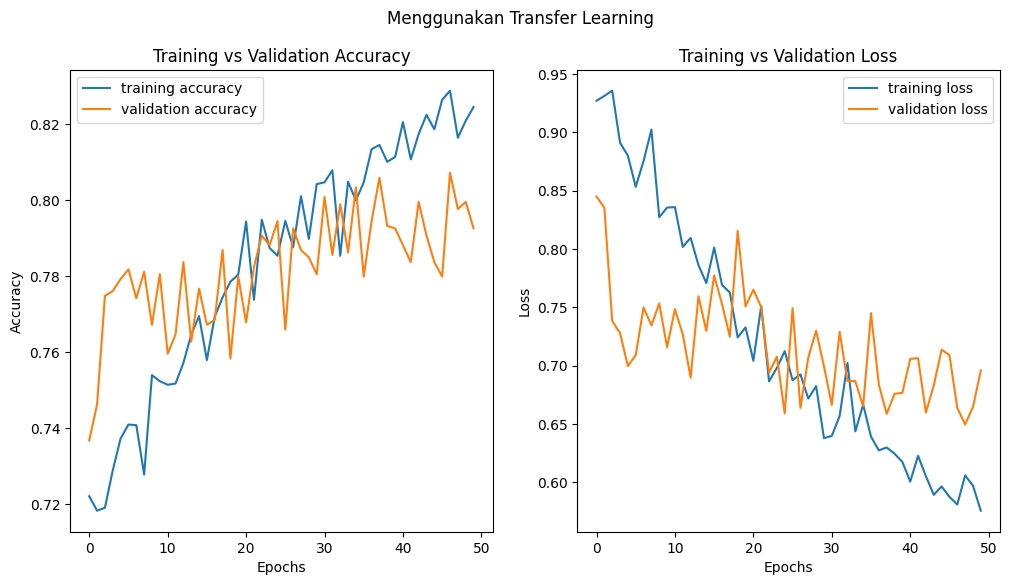

In [ ]:
plot_acc(history)

In [ ]:
model.save('model_AmbatoPlant_InceptionV3_15_class_V2.keras')

In [ ]:
!cp -r '/content/model_AmbatoPlant_InceptionV3_15_class_V2.keras' '/content/drive/MyDrive/Colab Notebooks/Model Inception 15 class'

Upload gambar yang ingin diprediksi:


Saving melati2.jpg to melati2.jpg

Hasil prediksi untuk gambar melati2.jpg:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


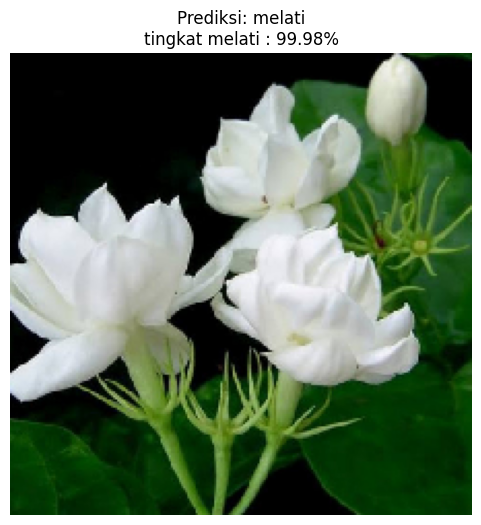

Kelas: melati
tingkat : melati 99.98%


In [ ]:
from google.colab import files

class_names = train.class_names

def predict_image(image_path, model, class_names):
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(224, 224)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f'Prediksi: {predicted_class}\ntingkat {predicted_class} : {confidence:.2%}')
    plt.axis('off')
    plt.show()

    return predicted_class, confidence

print("Upload gambar yang ingin diprediksi:")
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\nHasil prediksi untuk gambar {filename}:")
    predicted_class, confidence = predict_image(filename, model, class_names)
    print(f"Kelas: {predicted_class}")
    print(f"tingkat : {predicted_class} {confidence:.2%}")

# Retrain Model (V3)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Model Inception 15 class/model_AmbatoPlant_InceptionV3_15_class_V2.keras')

In [ ]:
history = model.fit(train_set, validation_data=val_set, epochs=50)

Epoch 1/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 50s 132ms/step - accuracy: 0.8247 - loss: 0.6093 - val_accuracy: 0.7798 - val_loss: 0.7195
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 77s 113ms/step - accuracy: 0.8447 - loss: 0.5376 - val_accuracy: 0.8039 - val_loss: 0.6871
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 44s 115ms/step - accuracy: 0.8256 - loss: 0.5746 - val_accuracy: 0.7843 - val_loss: 0.7092
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 44s 113ms/step - accuracy: 0.8257 - loss: 0.5958 - val_accuracy: 0.8065 - val_loss: 0.6719
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 43s 107ms/step - accuracy: 0.8376 - loss: 0.5317 - val_accuracy: 0.7874 - val_loss: 0.7188
Epoch 6/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 44s 106ms/step - accuracy: 0.8333 - loss: 0.5404 - val_accuracy: 0.7963 - val_loss: 0.6894
Epoch 7/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 44s 106ms/step - accuracy: 0.8372 - loss: 0.5498 - val_accuracy: 0.7951 - val_loss: 0.7092
Epoch 8/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 86s 130ms/step - accuracy: 0.8238 - loss: 0

KeyboardInterrupt: 

In [ ]:
def plot_acc(history):
  acc = history.history['accuracy']
  loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  epochs = len(acc)



  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

  ax[0].plot(range(epochs), acc, label='training accuracy')
  ax[0].plot(range(epochs), val_acc, label='validation accuracy')
  ax[0].legend()
  ax[0].set_title('Training vs Validation Accuracy')
  ax[0].set_ylabel('Accuracy')
  ax[0].set_xlabel('Epochs')

  ax[1].plot(range(epochs), loss, label='training loss')
  ax[1].plot(range(epochs), val_loss, label='validation loss')
  ax[1].legend()
  ax[1].set_title('Training vs Validation Loss')
  ax[1].set_ylabel('Loss')
  ax[1].set_xlabel('Epochs')

  plt.suptitle('Menggunakan Transfer Learning')
  fig.show()

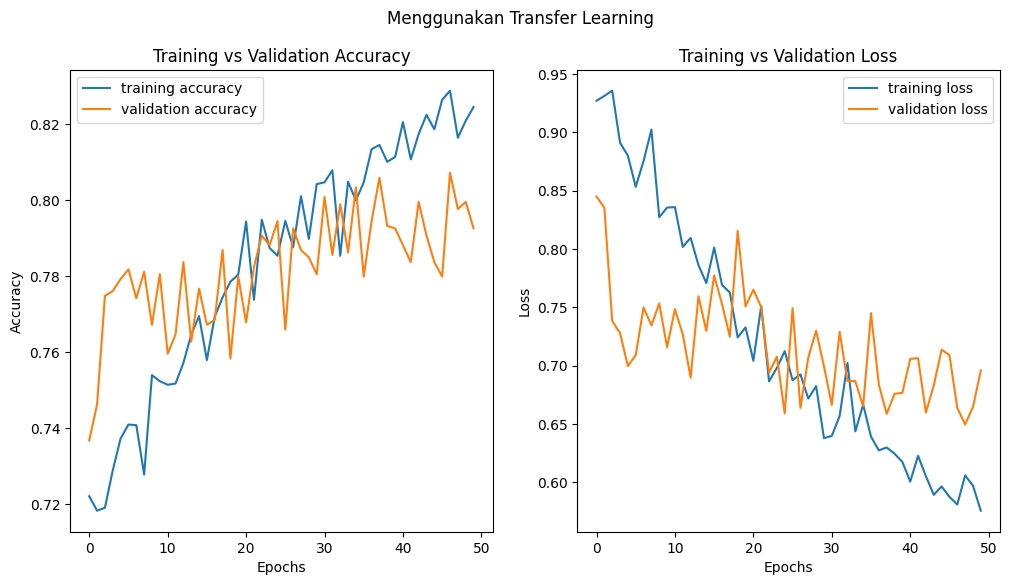

In [ ]:
plot_acc(history)

Upload gambar yang ingin diprediksi:


Saving melati.jpg to melati (1).jpg

Hasil prediksi untuk gambar melati (1).jpg:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


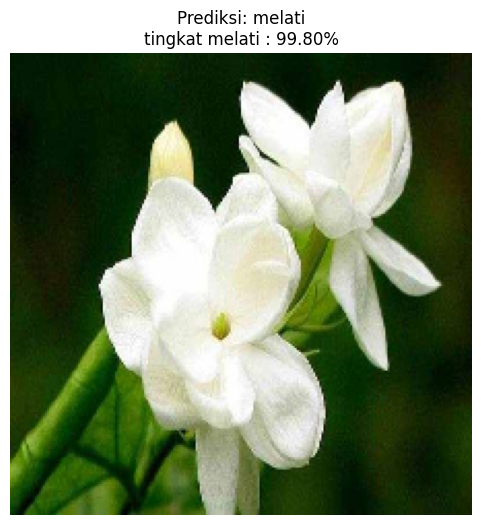

Kelas: melati
tingkat : melati 99.80%


In [ ]:
from google.colab import files

class_names = train.class_names

def predict_image(image_path, model, class_names):
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(224, 224)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f'Prediksi: {predicted_class}\ntingkat {predicted_class} : {confidence:.2%}')
    plt.axis('off')
    plt.show()

    return predicted_class, confidence

print("Upload gambar yang ingin diprediksi:")
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\nHasil prediksi untuk gambar {filename}:")
    predicted_class, confidence = predict_image(filename, model, class_names)
    print(f"Kelas: {predicted_class}")
    print(f"tingkat : {predicted_class} {confidence:.2%}")

In [ ]:
model.save('model_AmbatoPlant_InceptionV3_15_class_V3.keras')

In [ ]:
!cp -r '/content/model_AmbatoPlant_InceptionV3_15_class_V3.keras' '/content/drive/MyDrive/Colab Notebooks/Model Inception 15 class'

# Retrain Model (V4)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/capstone bangkit/model 15 class/model_AmbatoPlant_InceptionV3_15_class_V3.keras')

In [ ]:
history = model.fit(train_set, validation_data=val_set, epochs=50)

Epoch 1/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 68s 142ms/step - accuracy: 0.8390 - loss: 0.5282 - val_accuracy: 0.8103 - val_loss: 0.6442
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 47s 111ms/step - accuracy: 0.8457 - loss: 0.5105 - val_accuracy: 0.8147 - val_loss: 0.6506
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 83s 114ms/step - accuracy: 0.8509 - loss: 0.4976 - val_accuracy: 0.8122 - val_loss: 0.6420
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 47s 119ms/step - accuracy: 0.8514 - loss: 0.4859 - val_accuracy: 0.8084 - val_loss: 0.6593
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 45s 115ms/step - accuracy: 0.8570 - loss: 0.4741 - val_accuracy: 0.8115 - val_loss: 0.6898
Epoch 6/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 46s 109ms/step - accuracy: 0.8530 - loss: 0.4807 - val_accuracy: 0.8135 - val_loss: 0.6710
Epoch 7/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 47s 114ms/step - accuracy: 0.8497 - loss: 0.4966 - val_accuracy: 0.7900 - val_loss: 0.7312
Epoch 8/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 47s 120ms/step - accuracy: 0.8635 - loss: 0

In [ ]:
def plot_acc(history):
  acc = history.history['accuracy']
  loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  epochs = len(acc)



  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

  ax[0].plot(range(epochs), acc, label='training accuracy')
  ax[0].plot(range(epochs), val_acc, label='validation accuracy')
  ax[0].legend()
  ax[0].set_title('Training vs Validation Accuracy')
  ax[0].set_ylabel('Accuracy')
  ax[0].set_xlabel('Epochs')

  ax[1].plot(range(epochs), loss, label='training loss')
  ax[1].plot(range(epochs), val_loss, label='validation loss')
  ax[1].legend()
  ax[1].set_title('Training vs Validation Loss')
  ax[1].set_ylabel('Loss')
  ax[1].set_xlabel('Epochs')

  plt.suptitle('Menggunakan Transfer Learning')
  fig.show()

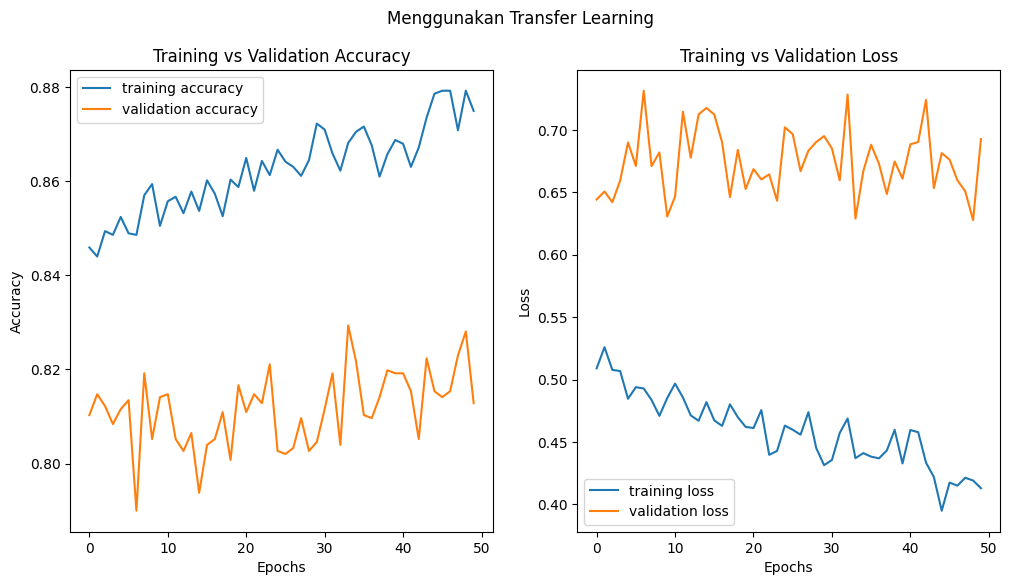

In [ ]:
plot_acc(history)

Upload gambar yang ingin diprediksi:


Saving jagung.jpg to jagung (1).jpg

Hasil prediksi untuk gambar jagung (1).jpg:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


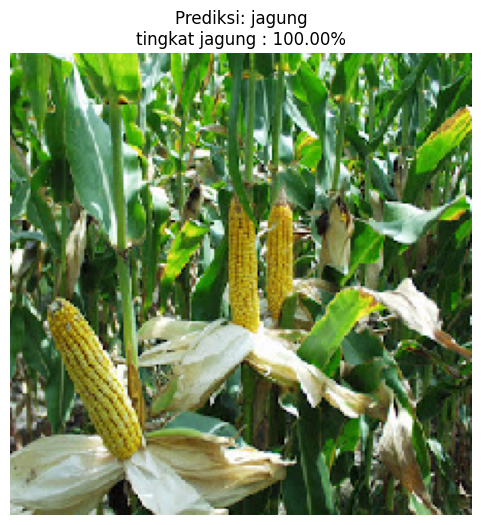

Kelas: jagung
tingkat : jagung 100.00%


In [ ]:
from google.colab import files

class_names = train.class_names

def predict_image(image_path, model, class_names):
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(224, 224)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f'Prediksi: {predicted_class}\ntingkat {predicted_class} : {confidence:.2%}')
    plt.axis('off')
    plt.show()

    return predicted_class, confidence

print("Upload gambar yang ingin diprediksi:")
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\nHasil prediksi untuk gambar {filename}:")
    predicted_class, confidence = predict_image(filename, model, class_names)
    print(f"Kelas: {predicted_class}")
    print(f"tingkat : {predicted_class} {confidence:.2%}")

In [ ]:
model.save('model_AmbatoPlant_InceptionV3_15_class_V4.keras')

In [ ]:
!cp -r '/content/model_AmbatoPlant_InceptionV3_15_class_V4.keras' '/content/drive/MyDrive/Colab Notebooks/capstone bangkit/model 15 class/'

# Build tflite

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/capstone bangkit/model 15 class/model_AmbatoPlant_InceptionV3_15_class_V3.keras')

In [ ]:
for index, class_name in enumerate(train.class_names):
  print(f"{index} = {class_name}")

0 = bunga_matahari
1 = delima
2 = gandum
3 = jagung
4 = jambu_batu
5 = kakao
6 = kamboja
7 = kelor
8 = lidah_buaya
9 = melati
10 = nanas
11 = okra
12 = singkong
13 = sorgum
14 = tomat


In [ ]:
# Initialize the TFLite Converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Convert the model
tflite_model = converter.convert()

# Save the TFLite model
with open("model_AmbatoPlant_InceptionV3_V3.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model has been successfully created!")

Saved artifact at '/tmp/tmpx1uj712h'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  139170635131088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139170635129504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139170635129856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139170635128272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139170635134960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139170635236096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139170635134256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139170635136544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139170635238912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139170635242784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139170635241

In [ ]:
!cp -r '/content/model_AmbatoPlant_InceptionV3_V3.tflite' '/content/drive/MyDrive/Colab Notebooks/capstone bangkit/model 15 class/'

Upload gambar yang ingin diprediksi:


Saving Beej-Swaraj-traditional-wheat-cultivation.jpg to Beej-Swaraj-traditional-wheat-cultivation (4).jpg

Hasil prediksi untuk gambar Beej-Swaraj-traditional-wheat-cultivation (4).jpg:
2


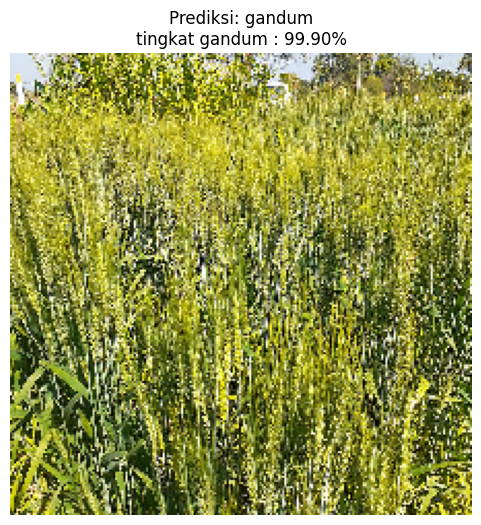

Kelas: gandum
tingkat : gandum 99.90%


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

class_names = train.class_names

def predict_image_tflite(image_path, interpreter, class_names):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(224, 224)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Set up the TFLite interpreter
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Set the input tensor
    interpreter.allocate_tensors()
    interpreter.set_tensor(input_details[0]['index'], img_array)

    # Run the inference
    interpreter.invoke()

    # Get the output tensor
    predictions = interpreter.get_tensor(output_details[0]['index'])[0]
    predicted_class = class_names[np.argmax(predictions)]
    print(np.argmax(predictions))
    confidence = np.max(predictions)

    # Display the result
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f'Prediksi: {predicted_class}\ntingkat {predicted_class} : {confidence:.2%}')
    plt.axis('off')
    plt.show()

    return predicted_class, confidence

# Load the TFLite model
tflite_model_path = "/content/drive/MyDrive/Colab Notebooks/capstone bangkit/model 15 class/model_AmbatoPlant_InceptionV3_V3.tflite"  # Update this with the path to your TFLite model
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)

print("Upload gambar yang ingin diprediksi:")
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\nHasil prediksi untuk gambar {filename}:")
    predicted_class, confidence = predict_image_tflite(filename, interpreter, class_names)
    print(f"Kelas: {predicted_class}")
    print(f"tingkat : {predicted_class} {confidence:.2%}")
